# Module 2 - Calculate land and water productivity and perfomance indicators

This Notebook calculates from seasonal WaPOR AETI, T and NPP data the following indicators

* Step 0 - Set up: Import modules/libraries, import data
* Step 1 - Calculate land and water productivity
      a. Total biomass production
      b. Yield*
      c. Biomass water productivity
      d. Crop water productivity*
* Step 2 - Calculate Irrigation performance indicators:
      a. Uniformity
      b. Beneficial fraction
      c. Adequacy
      d. Relative water deficit

*requires crop type information

#### <span style='background :lightgreen' > References:
* Chukalla, A. D., Mul, M. L., van der Zaag, P., van Halsema, G., Mubaya, E., Muchanga, E., den Besten, N., and Karimi, P.: [A framework for irrigation performance assessment using WaPOR data: the case of a sugarcane estate in Mozambique](https://doi.org/10.5194/hess-26-2759-2022), Hydrol. Earth Syst. Sci., 26, 2759–2778, 2022.

## Step 0 - Set up

## i) Import packages/libraries

In [1]:
!pip install rasterio --quiet
!pip install rioxarray --quiet

In [2]:
import os
import sys
import glob
import re                                 # re sub() module can be used to replace substring
import pandas as pd
import numpy as np
import rasterio as rio
import rioxarray as riox
import xarray as xr
import calendar
import datetime
from matplotlib import pyplot as plt
from osgeo import gdal

## ii) Import the input data
Importing required input data for the calculations (seasonal AETI, T and NPP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Or upload .zip file to the temporary repository

In [ ]:
#To upload zip file (pre-module 3 output).
from google.colab import files
uploaded = files.upload()

In [3]:
!unzip '/content/WaPORv3_clipped.zip' -d '/content'        # unzip WaPORv3 clipped outputs OR
#!unzip '/content/pyWaPOR_clipped.zip' -d '/content'        # unzip pyWaPOR clipped outputs

Archive:  /content/WaPORv3_clipped.zip
replace /content/content/clipped/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Connect to folders with seasonal WaPOR data

In [4]:
# get seasonal data
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/content/clipped"     #update directory
input_folderAETI  = os.path.join(dir_proj, dir_data, "AETI_season")
AETI_fhs = glob.glob(os.path.join(input_folderAETI, '*.tif'))
input_folderT  = os.path.join(dir_proj, dir_data, "T_season")
T_fhs = glob.glob(os.path.join(input_folderT, '*.tif'))
input_folderNPP  = os.path.join(dir_proj, dir_data, "NPP_season")
NPP_fhs = glob.glob(os.path.join(input_folderNPP, '*.tif'))


## Step 1: Calculate land and water productivity

Create output folders: Make one or connect to the existing one

In [5]:
# output_folder
output_folderTBP = r'/content/WaPORIPA/TotalBiomass'  # create output folder
TBP_fhs = glob.glob(r'/content/WaPORIPA/TotalBiomass/*.tif')
output_folderyield = r'/content/WaPORIPA/yield'  # create output folder
output_folderBWP = r'/content/WaPORIPA/BWP'  # create output folder
output_foldercWP = r'/content/WaPORIPA/cWP'  # create output folder

# Make one if the folder does not exit
if not os.path.exists(output_folderTBP):
    os.makedirs(output_folderTBP)
if not os.path.exists(output_folderyield):
    os.makedirs(output_folderyield)
if not os.path.exists(output_folderBWP):
    os.makedirs(output_folderBWP)
if not os.path.exists(output_foldercWP):
    os.makedirs(output_foldercWP)

### a) Calculate Total Seasonal Biomass Production

Net Primary Production can be used to estimate total biomass production using the following formula:

$TBP = (NPP *22.222)/1000$

The value 22.222 is to convert the NPP in gC/m^2 to biomass production in kg/ha. To convert to ton/ha the value is divided by 1000.

Review this script to check what each lines does.

the mean & SD for  = -145.8 & 107.0


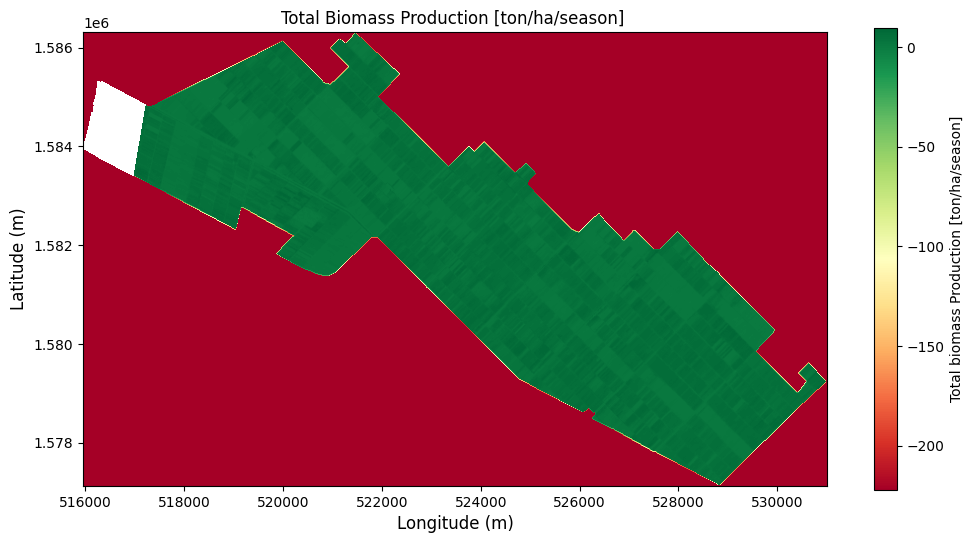

In [7]:
#Total seasonal biomass production
for in_fhsNPP in NPP_fhs:
  #for i, season in enumerate(season_periods):
    NPP  = riox.open_rasterio(in_fhsNPP, nan_values=True)
    TBP = (NPP * 22.222) / 1000  # Total biomass production, 1000 is to convert from kg to ton

    # save into output folder
    output_folder = output_folderTBP
    #out_fh = os.path.join(output_folderTBP, 'TBP'+ '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    basename = os.path.basename(in_fhsNPP).replace('NPP', 'TBP')
    out_fh = os.path.join(output_folderTBP, basename)

    TBP.rio.to_raster(out_fh)

    # Plot the raster map
    seasonal = TBP
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))


    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Total biomass Production [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Total Biomass Production [ton/ha/season] ')
    plt.clim()
    plt.show ();

### b) Calculate Yield

Crop parameters

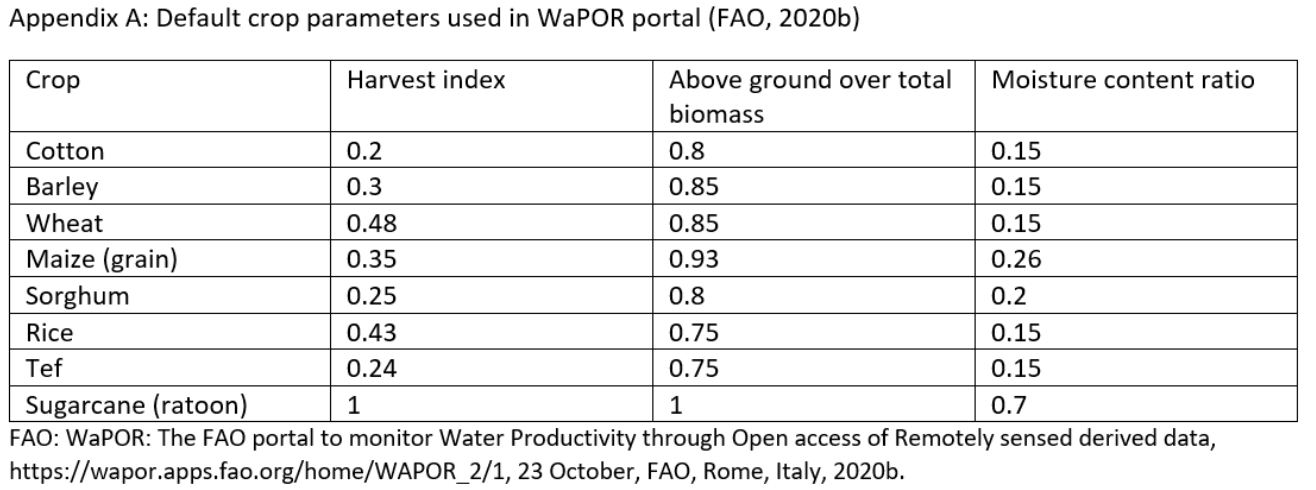

In [8]:
# Update the crop parameters specific to the crop
MC = 0.15  # moisture content, dry matter over fresh biomass
fc = 1.46  # Light use efficiency correction factor
AOT= 0.85  # above ground over total biomass production ratio(AOT)
HI = 0.48

In [12]:
for in_fhsTBP in TBP_fhs:
#for i, season in enumerate(season_periods):
    TBP  = riox.open_rasterio(in_fhsTBP, nan_values=True)
    Y = TBP * HI
    Y = HI * AOT * fc * (TBP / (1 - MC))

    # save into output folder
    output_folder = output_folderyield
    basename = os.path.basename(in_fhsTBP).replace('TBP', 'yield')
    out_fh = os.path.join(output_folderyield, basename)

    Y.rio.to_raster(out_fh)


    # Plot the raster map
    seasonal = Y
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Yield [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Yield [ton/ha/season] ')
    plt.clim()
    plt.show ()
    ;

### c) Calculate Water Productivity

Finally we will calculate biomass water productivity, which is defined as the total biomass production divided by the AETI:

    WPb = TBP/AETI * 100

The multiplication with 100 is needed to correct the units, first convert TBP in ton/ha to kg/m^2 (divide by 10) and then AETI from mm/season to m/season (divide by 1000) so that the final unit of WPb is kg/m^3

In [19]:
## Calculate biomass WP
for in_fhET, in_fhTBP in zip(AETI_fhs, TBP_fhs)
    AETI = riox.open_rasterio(in_fhET, nan_values=True)
    TBP = riox.open_rasterio(in_fhTBP, nan_values=True)
    WP  = TBP/AETI*100 # the multiplication with 100 is to correct the units to kg/m3 (from AETI in mm/season and TBP in ton/ha)


    # save into output folder
    output_folder = output_folderWP
    output_fh     = os.path.join(output_folder,'WP'+ '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    WP.rio.to_raster(output_fh)


    # Plot the raster map
    seasonal = WP
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())


    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(2),'&',np.nanstd(seasonal).round(2))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='WP [kg/m3]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Biomass water productivity [kg/m3]   ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ()
    ;

SyntaxError: expected ':' (<ipython-input-19-b829be448f60>, line 2)

### d) Calculate crop water productivity (defined as yield/AETI)

##Step 2: Calculate irrigation performance indicators
Create output folders: Make one or connect to the existing one

In [13]:
# output_folder
output_folderBF = r'/content/WaPORIPA/BeneficialFraction'  # create output folder
output_folderAd = r'/content/WaPORIPA/Adequacy'  # create output folder
output_folderRWD = r'/content/WaPORIPA/RWD'  # create output folder


# Make one if the folder does not exit
if not os.path.exists(output_folderBF):
    os.makedirs(output_folderBF)
if not os.path.exists(output_folderAd):
    os.makedirs(output_folderAd)
if not os.path.exists(output_folderRWD):
    os.makedirs(output_folderRWD)


### a) Calculate uniformity of water consumption
* Equity is defined as the coefficients of variation (CV) of seasonal ETa in the area of interest.
* It measures the evenness of the water supply in an irrigation scheme.
* Note: CV of 0 to 10% is good, 10 to 25% is fair and CV > 25% is poor uniformity (Bastiaanssen et al., 1996)
<br/>

In [14]:
# Uniformity of water Consumption

for i in range(len(AETI_fhs)):
    with rio.open(AETI_fhs[i]) as dataset:
        AETI = dataset.read(1)  # Read the first band

    AETIm = np.nanmean(AETI)
    AETIsd = np.nanstd(AETI)

    CV_AETI = (AETIsd / AETIm) * 100

    # Identify the date from the file name
    date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

    if CV_AETI < 10:
        U = 'Good Uniformity'
    elif 10 <= CV_AETI < 25:
        U = 'Fair Uniformity'
    else:
        U = 'Poor Uniformity'

    print('CV of AETI in', date, '=', round(CV_AETI, 1), ',', U)


CV of AETI in  season1 2022-10-01 to 2023-04-30 = -77.7 , Good Uniformity


### b) Calculate beneficial fraction
* Beneficial fraction is the ratio of the water that is consumed as transpiration compared to overall field water consumption (ETa).

$Beneficial fraction = \frac{T_a}{ET_a}$
* It is a measure of the efficiency of on farm water and agronomic practices in use of water for crop growth.

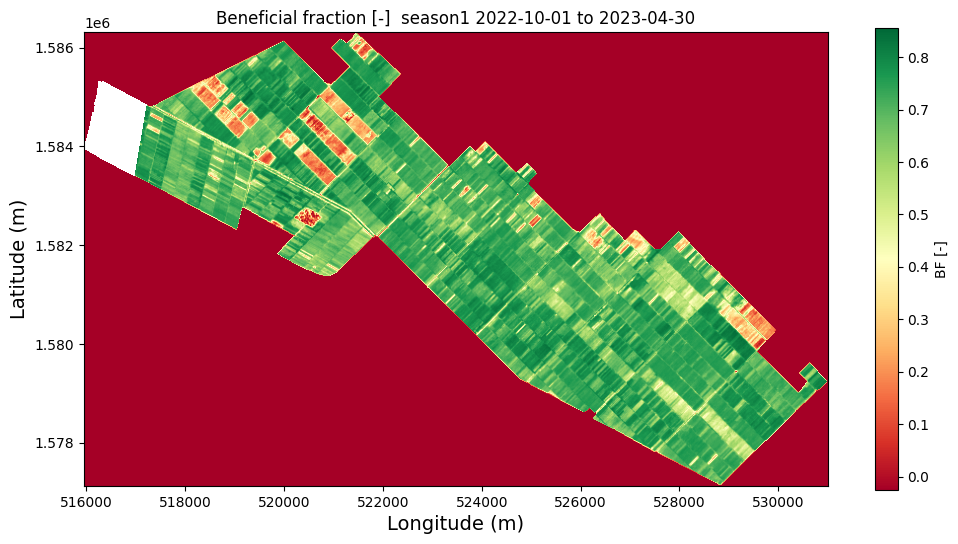

In [15]:
# Beneficial fraction
for Tfh, ETfh in zip(T_fhs, AETI_fhs):
    try:
        T = riox.open_rasterio(Tfh)
        AETI = riox.open_rasterio(ETfh)

        T_over_AETI = T / AETI

        # Get spatial extent
        spatial_extent = (T_over_AETI.x.min(), T_over_AETI.x.max(), T_over_AETI.y.min(), T_over_AETI.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'BF')
        output_fn = os.path.join(output_folderBF, basename)
        T_over_AETI.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = T_over_AETI.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='BF [-]')
        plt.xlabel('Longitude (m)', fontsize=14)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=14)
        plt.title('Beneficial fraction [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")



### c) Calculate adequacy (relative evapotranspiration)
$Adequacy= \frac{ET_a}{ET_p}$

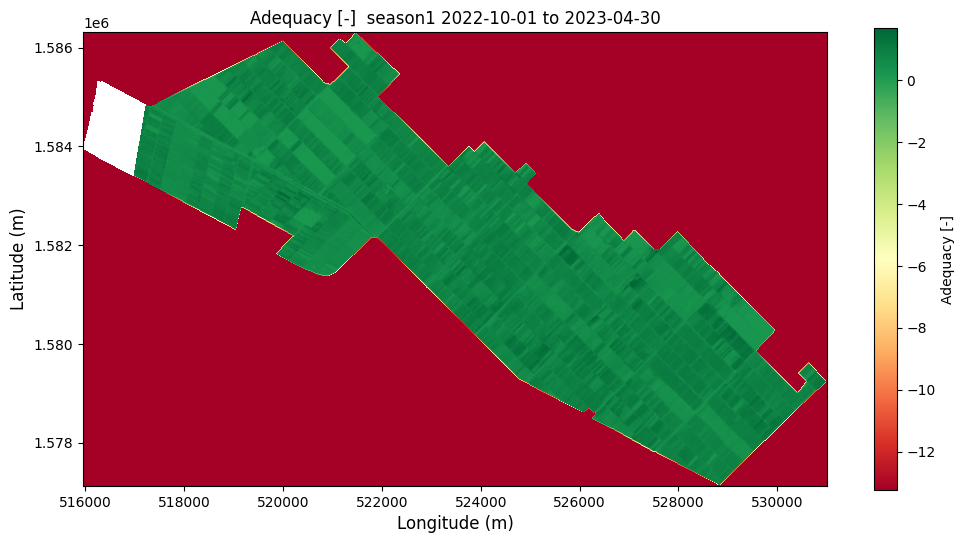

In [16]:
# Adequacy
for ETfh in AETI_fhs:
    try:
        AETI = riox.open_rasterio(ETfh)

        # Compute ETp as the 95th percentile of AETI
        ETp_value = np.nanpercentile(AETI.values, 95)
        ETp = xr.full_like(AETI, ETp_value)

        ETa_by_ETp = AETI / ETp

        # Get spatial extent
        spatial_extent = (ETa_by_ETp.x.min(), ETa_by_ETp.x.max(), ETa_by_ETp.y.min(), ETa_by_ETp.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'Adequacy')
        output_fn = os.path.join(output_folderAd, basename)
        ETa_by_ETp.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = ETa_by_ETp.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='Adequacy [-]')
        plt.xlabel('Longitude (m)', fontsize=12)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.title('Adequacy [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")

### d) Calculate Relative Water Deficit (RWD)
$RWD= 1-\frac{ET_a}{ET_x}$

<br/>${ET_x} = $ Can be ETp or 99 percentile of the actual evapotranspiration

In [17]:
# Relative water deficit
# Collecting GeoInfo such as projection, the x and y axis from the first file
in_fh = AETI_fhs[0]
AETI_extend = riox.open_rasterio(in_fh)
spatial_extent = (AETI_extend.x.min(), AETI_extend.x.max(), AETI_extend.y.min(), AETI_extend.y.max())

for i in range(len(AETI_fhs)):
    try:
        # Open the AETI file using rioxarray
        AETI = riox.open_rasterio(AETI_fhs[i])

        # Reshape the array
        AETI1_1D = np.reshape(AETI.values, AETI.shape[1] * AETI.shape[2])
        ETx = np.nanpercentile(AETI1_1D, 95)

        AETI_mean = np.nanmean(AETI.values)

        RWD = 1 - (AETI_mean / ETx)

        # Identify the date from the file name
        date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

        print('Relative water deficit', date, '=', round(RWD, 2))

    except Exception as e:
        print(f"An error occurred with file {AETI_fhs[i]}: {e}")


Relative water deficit  season1 2022-10-01 to 2023-04-30 = 9.51


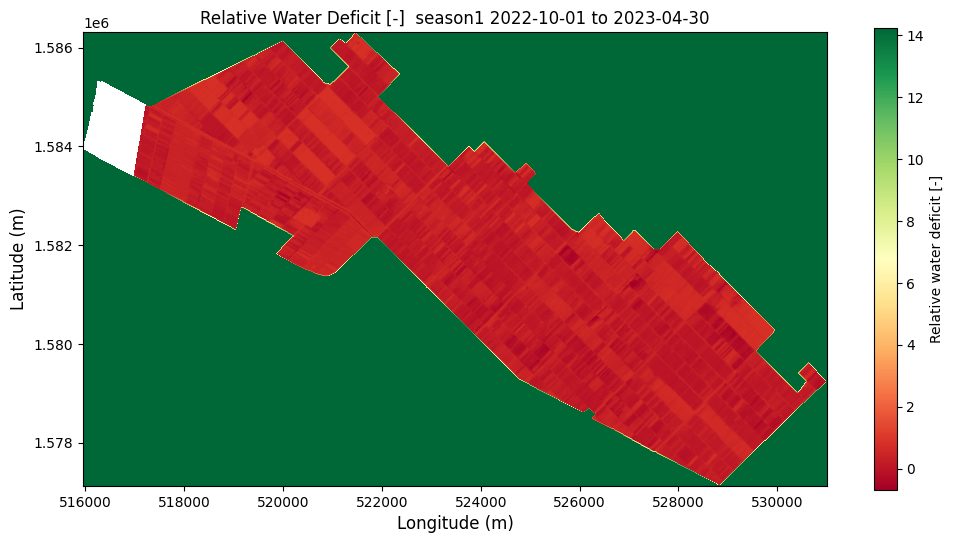

In [18]:
# Relative water deficit (spatial)
# Collecting GeoInfo such as projection, the x and y axis from the first file
in_fh = AETI_fhs[0]
AETI_extend = riox.open_rasterio(in_fh)
spatial_extent = (AETI_extend.x.min(), AETI_extend.x.max(), AETI_extend.y.min(), AETI_extend.y.max())

for i in range(len(AETI_fhs)):
    try:
        # Open the AETI file using rioxarray
        AETI = riox.open_rasterio(AETI_fhs[i])

        # Reshape the array
        AETI1_1D = np.reshape(AETI.values, AETI.shape[1] * AETI.shape[2])
        ETx = np.nanpercentile(AETI1_1D, 95)

        AETI_mean = np.nanmean(AETI.values)

        RWD = 1 - (AETI / ETx)

        # Identify the date from the file name
        output_folder = output_folderRWD
        basename = os.path.basename(in_fh).replace('AETI', 'RWD')
        out_fh = os.path.join(output_folderRWD, basename)

        RWD.rio.to_raster(out_fh)

        #print('Relative water deficit', date, '=', round(RWD, 2))

# Plot the raster map
        seasonal = RWD.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='Relative water deficit [-]')
        plt.xlabel('Longitude (m)', fontsize=12)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.title('Relative Water Deficit [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")


Download files

In [19]:
!zip -r /content/WaPORIPA.zip /content/WaPORIPA
from google.colab import files
files.download(r'/content/WaPORIPA.zip')

  adding: content/WaPORIPA/ (stored 0%)
  adding: content/WaPORIPA/Adequacy/ (stored 0%)
  adding: content/WaPORIPA/Adequacy/Adequacy_season1_2022-10-01_to_2023-04-30.tif (deflated 86%)
  adding: content/WaPORIPA/BeneficialFraction/ (stored 0%)
  adding: content/WaPORIPA/BeneficialFraction/BF_season1_2022-10-01_to_2023-04-30.tif (deflated 68%)
  adding: content/WaPORIPA/TotalBiomass/ (stored 0%)
  adding: content/WaPORIPA/TotalBiomass/TBP_season1_2022-10-01_to_2023-04-30.tif (deflated 68%)
  adding: content/WaPORIPA/cWP/ (stored 0%)
  adding: content/WaPORIPA/yield/ (stored 0%)
  adding: content/WaPORIPA/BWP/ (stored 0%)
  adding: content/WaPORIPA/RWD/ (stored 0%)
  adding: content/WaPORIPA/RWD/RWD_season1_2022-10-01_to_2023-04-30.tif (deflated 86%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>